### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import pandas as pd

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
print(Time_matrix.shape)
print(Time_matrix[0][1][23][1])

(5, 5, 24, 7)
3.0


## Test Rig for Environment 

In [3]:
driver_env=CabDriver()

print('Action Space is : ', driver_env.action_space)
print('Lenght of Action Space is: ', len(driver_env.action_space))
#print('State Space is : ', driver_env.state_space)
print('Length of State Space is : ', len(driver_env.state_space))
print('Initial State : ', driver_env.state_init)

Action Space is :  [(1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (0, 0)]
Lenght of Action Space is:  21
Length of State Space is :  840
Initial State :  (3, 14, 5)


In [4]:
# Check Requests
possible_actions_ind,acts=driver_env.requests(driver_env.state_init)
print('Possible actions index' ,possible_actions_ind )
print('actions list ',acts)

# select random action
rand_action_ind=np.random.choice(np.arange(0,len(possible_actions_ind)))
print(rand_action_ind)
action=acts[rand_action_ind]
print('Random Action Selected : ',action)

# Check Rewards Earned and Next state for random Action
reward_value=driver_env.reward_func(driver_env.state_init,action,Time_matrix)
next_states=driver_env.next_state_func(driver_env.state_init,action,Time_matrix)
print('Reward Value : ',reward_value)
print('Next State Value : ',next_states)

# Check Rewards Earned and Next state for Action - (0,0) - Driver didn't take any request.
reward_value=driver_env.reward_func(driver_env.state_init,(0,0),Time_matrix)
next_states=driver_env.next_state_func(driver_env.state_init,(0,0),Time_matrix)
print('Reward Value : ',reward_value)
print('Next State Value : ',next_states)

Possible actions index [17, 19, 8, 15, 2]
actions list  [(5, 2), (5, 4), (3, 1), (4, 5), (1, 4)]
3
Random Action Selected :  (4, 5)
Reward Value :  -16
Next State Value :  (5, 4, 6)
Reward Value :  0
Next State Value :  (3, 15, 5)


In [5]:
terminal_flag=driver_env.check_if_terminal(driver_env.state_init,acts[0],Time_matrix)

In [40]:
episodes_vs_rewards=pd.DataFrame(data={'Accumulated_Rewards':accu_rewards,
                                      'Total_Time':total_time,
                                      'Episode_Number':episode_num})
episode_num=[0]
accu_rewards=[0]
total_time=[0]
episodes_max=100

for i in range(1,episodes_max+1):
    driver_env=CabDriver()
    state=driver_env.state_init
    terminal_flag=False
    while not terminal_flag:
        # random action selection
        possible_actions_ind,acts=driver_env.requests(state)
        # Poission Distribution can some times give 0 actions
        if len(possible_actions_ind) != 0:
            rand_action_ind=np.random.choice(np.arange(0,len(possible_actions_ind)))
            action=acts[rand_action_ind]
            # calculate reward
            reward_value=driver_env.reward_func(state,action,Time_matrix)
            # Calculate next Section
            next_state=driver_env.next_state_func(state,action,Time_matrix)
            #check if terminal state
            terminal_flag=driver_env.check_if_terminal(state,action,Time_matrix)
            # copy next state to current state
            state=next_state          
            
    tot_rewards,tot_time=driver_env.tracking_info()
    episode_num.append(i)
    accu_rewards.append(tot_rewards)
    total_time.append(tot_time)

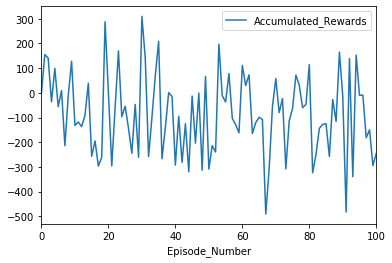

In [41]:
# Plot rewards vs Episodes
episodes_vs_rewards.plot(x='Episode_Number',y='Accumulated_Rewards')

In [42]:
state_encode=driver_env.state_encod_arch1(driver_env.state_init)
print(state_encode)

[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


#### Tracking the state-action pairs for checking convergence


In [3]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01   
        self.epsilon_max = 1
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.01
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        
        input_shape = self.state_size

        model = Sequential()

        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(0.25))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

        return model

    def get_action(self, state):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        """
        get action in a state according to an epsilon-greedy approach
        """

        if np.random.rand() <= self.epsilon_max:
            return random.randrange(self.action_size)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    def append_sample(self, state, action, reward, next_state):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
       self.memory.append((state, action, reward, next_state))
   
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """
        train the neural network on a minibatch. Input to the network is the states,
        output is the target q-value corresponding to each action.
        """
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
         
            action, reward = [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state
 
            # predict the target q-values from states s
            target = self.model.predict(update_input)

            # target for q-network
            target_qval = self.model.predict(update_output)

            # update the target values
            for i in range(self.batch_size):
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save(self, name):
        self.model.save(name)

In [12]:
Episodes = 

### DQN block

In [ ]:
for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    

    #Call the DQN agent
    
    
    while !terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        

### Tracking Convergence

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [6]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

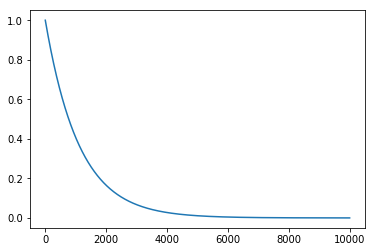

In [7]:
plt.plot(time, epsilon)
plt.show()